# NEO4J

Comenzamos importando las librerías que vamos a utilizar, y cargando la extensión `ipython-cypher` para poder lanzar consultas Cypher directamente a través del *notebook*.
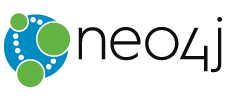

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [22]:
!pip install ipython-cypher

In [23]:
%load_ext cypher
%config CypherMagic.uri='http://neo4j:7474/db/data'

The cypher extension is already loaded. To reload it, use:
  %reload_ext cypher


In [24]:
%config CypherMagic.auto_html=False

Primero se crea un índice sobre el atributo `Id` de `User`, que se usará después para crear usuarios y relacionarlos con la pregunta o respuesta que se ha leído. Si no se hace esto, la carga del CSV es muy lenta.

In [25]:
%%cypher
CREATE INDEX ON :User(Id);

0 rows affected.


[]

El siguiente código carga el CSV de las preguntas y respuestas. El código primero todos los nodos con la etiqueta `Post`, y después añade la etiqueta `Question` ó `Answer` dependiendo del valor del atributo `PostTypeId`.

In [26]:
%%cypher
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "http://neuromancer.inf.um.es:8080/es.stackoverflow/Posts.csv" AS row
    CREATE (n)
    SET n=row
    SET n :Post
    ;

76278 nodes created.
1601838 properties set.
76278 labels added.


[]

A todas las preguntas, se las etiqueta con `Question`.

In [27]:
%%cypher
MATCH (n:Post {PostTypeId : "1"})
  SET n:Question;

32463 labels added.


[]

A todas las respuestas se las etiqueta con `Answer`.

In [28]:
%%cypher
MATCH (n:Post {PostTypeId : "2"})
  SET n:Answer;

41513 labels added.


[]

Se crea un nodo usuario (o se utiliza uno si ya existe) usando el campo `OwnerUserId`, siempre que no esté vacío. Nótese que se puede utilizar `CREATE` porque esta combinación de relación usuario y pregunta no existe. Cuidado, si se ejecuta dos veces creará el doble de relaciones.

In [29]:
%%cypher
MATCH (n:Post)
WHERE n.OwnerUserId <> ""
    MERGE (u:User {Id: n.OwnerUserId})
    CREATE (u)-[:WROTE]->(n);

14508 nodes created.
14508 properties set.
75996 relationships created.
14508 labels added.


[]

Creamos un índice sobre el `Id` para acelerar las siguientes búsquedas:

In [30]:
%%cypher
CREATE INDEX ON :Post(Id);

0 rows affected.


[]

Añadimos una relación entre las preguntas y las respuestas:

In [31]:
%%cypher
MATCH (a:Answer), (q:Question {Id: a.ParentId})
CREATE (a)-[:ANSWERS]->(q)
;

41513 relationships created.


[]

Y finalmente, la creación de relaciones `:RECIPROCATE` entre los usuarios. Se introduce también la construcción `WITH`.

`WITH` sirve para introducir "espacios de nombres". Permite importar nombres de filas anteriores, hacer alias con `AS` e introducir nuevos valores con funciones de Cypher. La siguiente consulta es la misma de arriba, RQ4, pero creando relaciones `:RECIPROCATE` entre cada dos usuarios que se ayudan recíprocamente.

In [32]:
%%cypher
// RQ4 creando relaciones de reciprocidad
MATCH
  (u1:User)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u2:User), (u2)-[:WROTE]->()-[:ANSWERS]->()<-[:WROTE]-(u1)
WHERE u1 <> u2 AND u1.Id < u2.Id
WITH u1 AS user1,u2 AS user2
MERGE (user1)-[:RECIPROCATE]->(user2)
MERGE (user1)<-[:RECIPROCATE]-(user2)
;

232 relationships created.


[]

## EJERCICIO 1: Construir los nodos `:Tag` para cada uno de los tags que aparecen en las preguntas. Construir las relaciones `post-[:TAGGED_BY]->tag` para cada tag y también `tag-[:TAGS]->post`

Para poder construir los nodos `:Tag` hemos hecho uso de las funciones `split()` y `substring()`, y de las construcciones `UNWIND` y `WITH`. El proceso de separación de los tags comienza eliminando el primer y el último carácter del valor `Tags` de los nodos `Post`, y separándolos en una lista usando como separador `><`. A continuación, aplicamos `UNWIND` sobre esa lista de tags separados para expandirlos en un conjunto de filas. Por último, para cada tag creamos un nodo con su nombre, y añadimos las relaciones `:TAGGED_BY` y `:TAGS` con el post. Es importante mencionar que usamos `CREATE` para crear las relaciones y no `MERGE`, debido a que el primero es más rápido. Sin embargo, no se debe volver a ejecutar el código porque si no crearíamos relaciones repetidas. Por otro lado, usamos `MERGE` para crear los nodos, ya que esa cláusula va a ejecutarse varias veces por cada tag, y hemos de asegurarnos de que solo se crean una vez. También es importante comentar que en la cláusula `WITH` hemos añadido cada post (`n`), ya que si no se incluye ahí no se puede usar para crear las relaciones justo después.

In [33]:
%%cypher
MATCH (n:Post)
WHERE n.Tags <> ""
WITH n, split(substring(substring(n.Tags,1),0,size(n.Tags)-2),"><") AS tags
UNWIND tags AS tag
MERGE (t:Tag {name: tag})
CREATE (n)-[:TAGGED_BY]->(t)
CREATE (t)-[:TAGS]->(n);

1554 nodes created.
1554 properties set.
152164 relationships created.
1554 labels added.


[]

La siguiente consulta muestra los usuarios que preguntan por cada Tag:

In [34]:
%%cypher
MATCH (t:Tag)-->(:Question)<--(u:User) RETURN t.name AS Tag,collect(distinct u.Id) AS Users ORDER BY t.name;

1549 rows affected.


[['.asmx', ['43605', '23683', '9885', '4361', '24842', '27002', '9039']],
 ['.htaccess',
  ['7358',
   '9142',
   '26878',
   '7498',
   '21882',
   '9754',
   '26657',
   '16978',
   '10796',
   '3248',
   '25908',
   '25829',
   '11349',
   '35768',
   '15481',
   '27826',
   '33462',
   '4571',
   '52463',
   '5583',
   '18587',
   '6897',
   '29516',
   '19419',
   '10365',
   '45740',
   '4530',
   '55754',
   '15594',
   '20493',
   '166',
   '37608',
   '2676',
   '55288',
   '30152',
   '7679',
   '20709',
   '29967',
   '52036',
   '54420',
   '8752',
   '5248',
   '35340',
   '4718',
   '18124',
   '10486',
   '36049',
   '15653',
   '9470',
   '37695',
   '9529',
   '6187',
   '21670',
   '27226',
   '47637',
   '51884',
   '23610',
   '18771',
   '14025',
   '27916',
   '4328',
   '16107',
   '30706',
   '11342',
   '10399',
   '54489',
   '46275',
   '56955',
   '36157',
   '32994',
   '6044',
   '31455',
   '12545',
   '13041',
   '14132',
   '55890',
   '5438',
   '5716',
   '37364',
   '18031',
   '6046',
   '517',
   '2770',
   '872',
   '27667',
   '3947',
   '9254',
   '49661',
   '1746',
   '18000']],
 ['.htpasswd', ['5716']],
 ['.net',
  ['52400',
   '9947',
   '3022',
   '15596',
   '33042',
   '2896',
   '30131',
   '547',
   '22205',
   '6764',
   '28475',
   '4361',
   '4499',
   '5715',
   '15439',
   '31656',
   '50737',
   '17625',
   '22324',
   '4914',
   '30762',
   '24842',
   '37794',
   '7545',
   '33213',
   '28050',
   '9883',
   '22387',
   '3541',
   '33073',
   '3008',
   '21979',
   '15301',
   '21904',
   '5723',
   '38929',
   '1962',
   '41156',
   '30038',
   '2883',
   '3088',
   '29296',
   '53738',
   '51058',
   '21471',
   '5729',
   '28831',
   '35183',
   '22584',
   '2247',
   '55221',
   '3249',
   '13432',
   '47330',
   '12891',
   '14461',
   '54329',
   '8873',
   '15562',
   '1274',
   '30509',
   '57302',
   '3142',
   '46542',
   '22571',
   '30353',
   '4610',
   '1168',
   '51933',
   '47536',
   '57466',
   '5271',
   '23697',
   '21459',
   '27833',
   '28772',
   '56513',
   '45449',
   '4779',
   '35781',
   '15572',
   '40712',
   '7273',
   '298',
   '28378',
   '14211',
   '745',
   '48505',
   '54092',
   '12640',
   '40501',
   '26195',
   '24364',
   '10744',
   '33484',
   '13701',
   '1482',
   '2945',
   '5668',
   '44985',
   '2946',
   '10428',
   '15270',
   '531',
   '24867',
   '25708',
   '14706',
   '26651',
   '29261',
   '5671',
   '22698',
   '3879',
   '5866',
   '15710',
   '40111',
   '37542',
   '56428',
   '27634',
   '28472',
   '463',
   '23',
   '35733',
   '7132',
   '22242',
   '30129',
   '46154',
   '2947',
   '49228',
   '21643',
   '4048',
   '6298',
   '32336',
   '2004',
   '29028',
   '4748',
   '7491',
   '10952',
   '41515',
   '57087',
   '30514',
   '7254',
   '10686',
   '7692',
   '54012',
   '3803',
   '16744',
   '4787',
   '57161',
   '6791',
   '27705',
   '55738',
   '39984',
   '29875',
   '1473',
   '27435',
   '9130',
   '9476',
   '7216',
   '51093',
   '51862',
   '3544',
   '55451',
   '21180',
   '18737',
   '6808',
   '14236',
   '13526',
   '18477',
   '5997',
   '26903',
   '12902',
   '43085',
   '22005',
   '48401',
   '27002',
   '16449',
   '31660',
   '33834',
   '562',
   '48060',
   '7242',
   '35795',
   '22395',
   '55233',
   '5811',
   '2224',
   '38307',
   '45739',
   '38309',
   '4574',
   '34427',
   '2488',
   '6881',
   '45649',
   '3727',
   '4612',
   '921',
   '47359',
   '5602',
   '15284',
   '30839',
   '57448',
   '56976',
   '8990',
   '19052',
   '34051',
   '15675',
   '250',
   '30722',
   '14181',
   '15883',
   '29179',
   '822',
   '34194',
   '11354']],
 ['.net-core', ['30353']],
 ['2d', ['39510', '13724', '2257', '5449', '27229']],
 ['3d',
  ['23739',
   '342',
   '2998',
   '46230',
   '22584',
   '44032',
   '30578',
   '25764',
   '20401']],
 ['abap', ['1098', '19839']],
 ['accesibilidad', ['250', '29967']],
 ['access-control', ['7246']],
 ['accordion', ['33075', '46464'

El mismo `MATCH` se puede usar para encontrar qué conjunto de tags ha usado cada usuario cambiando lo que retornamos:

In [35]:
%%cypher
MATCH (t:Tag)-->(:Question)<--(u:User) RETURN u.Id AS User, collect(distinct t.name) AS Tags ORDER BY toInt(u.Id);

10939 rows affected.


[['20', ['typescript']],
 ['21',
  ['delphi',
   'string',
   'casting',
   'array',
   'javascript',
   'jquery',
   'android',
   'socket',
   'tcpip',
   'tcp',
   'mysql',
   'datetime',
   'timestamp',
   'sql',
   'join',
   'oracle',
   'oracle-10g',
   'poo',
   'windows',
   'split',
   'sobrecarga',
   'pascal',
   'impresión',
   'lenguaje-compilado']],
 ['22',
  ['array',
   'perl',
   'javascript',
   'jquery',
   'git',
   'nodejs',
   'json',
   'sandbox',
   'seguridad',
   'tipos',
   'booleano',
   'pouchdb',
   'go',
   'conversión-de-tipos',
   'eventos',
   'atómico']],
 ['23',
  ['.net',
   'asp.net-web-api',
   'asp.net',
   'google-maps',
   'angularjs',
   'jasmine',
   'karma-jasmine',
   'javascript',
   'momentjs',
   'c#',
   'git',
   'ajax',
   'mercurial']],
 ['24',
  ['c++',
   'string',
   'casting',
   'android',
   'c++11',
   'c#',
   'java',
   'linux',
   'c',
   'tokens',
   'android-studio',
   'gradle',
   'angularjs-2.0',
   'angular2-template',
   'vscode',
   'arquitectura',
   'compilador',
   'gnu',
   'interprete',
   'terminal']],
 ['25',
  ['c++',
   'array',
   'javascript',
   'c++11',
   'c#',
   'java',
   'git',
   'nodejs',
   'xml',
   'licencias',
   'código-abierto',
   'visual-studio-2015',
   'revisión-de-código',
   'groovy']],
 ['27', ['javascript', 'android', 'reactjs', 'react-native']],
 ['29', ['ruby-on-rails', 'ruby', 'vistas', 'api', 'http', 'post']],
 ['34', ['ruby-on-rails', 'html', 'css']],
 ['35', ['asp.net', 'javascript', 'bower', 'kendoui', 'knockoutjs']],
 ['37', ['ios', 'xcode', 'lista', 'elixir']],
 ['39',
  ['ruby-on-rails', 'ruby', 'javascript', 'nodejs', 'ecmascript-2015', 'es6']],
 ['45', ['sql', 'tsql']],
 ['65',
  ['array',
   'javascript',
   'jquery',
   'google-apps-script',
   'google-hoja-de-calculo',
   'google-forms',
   'google-documentos',
   'html',
   'css',
   'regex',
   'optimización',
   'dom',
   'excel',
   'bookmarklet',
   'gmail',
   'google-chrome',
   'google-drive',
   'revisión-de-código',
   'geo-localizacion',
   'fecha',
   'formulas',
   'csv',
   'google-sites',
   'google-drive-sdk',
   'es2016',
   'google-caja']],
 ['72', ['c#']],
 ['73',
  ['javascript',
   'php',
   'ajax',
   'laravel',
   'laravel-5',
   'html',
   'css',
   'html5',
   'css3',
   'condiciones',
   'revisión-de-código']],
 ['74', ['array', 'python', 'numpy', 'yield', 'pandas']],
 ['75',
  ['ruby',
   'git',
   'control-de-versiones',
   'reactjs',
   'conflictos',
   'bundler',
   'gemfile']],
 ['77', ['sql', 'sql-server']],
 ['78',
  ['asp.net',
   'javascript',
   'sql',
   'c#',
   'html',
   'windows-forms',
   'sql-server',
   'sharepoint',
   'sharepoint-online',
   'excel',
   'windows',
   'ms-access-2010',
   'google-chrome',
   'consola',
   'jquery-datepicker',
   'revisión-de-código',
   'vb6',
   'regsvr32',
   'webforms',
   'impresión',
   'ddl',
   'ms-access',
   'sftp']],
 ['83',
  ['string',
   'bash',
   'archivo',
   'python',
   'git',
   'html',
   'css',
   'linux',
   'shell',
   'sed',
   'awk',
   'regex',
   'git-commit',
   'coma-flotante',
   'zsh',
   'python-2.7',
   'git-push',
   'git-merge',
   'css3',
   'nodejs',
   'npm',
   'python-3.x',
   'sql-server',
   'unix',
   'grep',
   'ascii',
   'crontab',
   'vim',
   'find',
   'redux',
   'cron',
   'parámetros',
   'números-enteros',
   'línea-de-comandos',
   'shell-interactiva',
   'vi',
   'diccionarios',
   'git-rebase']],
 ['90', ['mysql', 'sql']],
 ['92', ['c#', 'wpf', 'xaml', 'reflexión']],
 ['93', ['javascript', 'java', 'css', 'eclipse', 'visual-studio', 'swt']],
 ['95',
  ['string',
   'javascript',
   'android',
   'java',
   'regex',
   'google-newsstand-producer',
   'rss',
   'objective-c',
   'swift',
   'base-de-datos',
   'uiwebview',
   'dialogo',
   'android-glide',
   'jira']],
 ['100',
  ['string',
   'array',
   'lista',
   'javascript',
   'jquery',
   'android',
   'mysql',
   'datetime',
   'bash',
   'archivo',
   'python',
   'lin

## EJERCICIO 2: Relacionar cada usuario con los tags de sus preguntas a través de la relación `:INTERESTED_IN` (similar a E1).

Para crear la relación `:INTERESTED_IN`, al contrario que en las relaciones del ejercicio anterior, hemos de usar `MERGE`, ya que si no crearíamos relaciones repetidas (un usuario puede estar interesado en un mismo tag a través de varias preguntas).

Para obtener los tags de las preguntas de cada usuario, usamos `-->` para especificar que queremos todos los tags que estén relacionados con una pregunta (se omite la relación, pero sabemos que la única es `:TAGS`), que a la vez estén relacionados con uno o más usuarios (a través de `:WROTE`). Cuando ya tenemos cada usuario y cada tag, se crea la relación usando `MERGE`, como acabamos de indicar.

In [36]:
%%cypher
MATCH (t:Tag)-->(:Question)<--(u:User)
MERGE (u)-[:INTERESTED_IN]->(t)

45059 relationships created.


[]

A modo de ejemplo, para cada usuario cuyo `Id` es menor que 24, mostramos cada uno de los tags en los que está interesado. Podemos observar que los resultados para los tags son los mismos que en la última consulta mostrada en el ejercicio anterior, pero cambiando el orden de algunos de ellos.

In [38]:
%%cypher
MATCH (u:User)-[:INTERESTED_IN]->(t:Tag)
WHERE toInt(u.Id) < 24 
RETURN u.Id AS User, collect(distinct t.name) AS Tags
ORDER BY toInt(u.Id)

4 rows affected.


[['20', ['typescript']],
 ['21',
  ['tcp',
   'javascript',
   'datetime',
   'delphi',
   'oracle-10g',
   'tcpip',
   'timestamp',
   'join',
   'poo',
   'socket',
   'mysql',
   'casting',
   'sobrecarga',
   'split',
   'impresión',
   'jquery',
   'string',
   'windows',
   'sql',
   'pascal',
   'oracle',
   'lenguaje-compilado',
   'android',
   'array']],
 ['22',
  ['git',
   'javascript',
   'eventos',
   'nodejs',
   'array',
   'pouchdb',
   'seguridad',
   'json',
   'conversión-de-tipos',
   'perl',
   'go',
   'sandbox',
   'booleano',
   'tipos',
   'jquery',
   'atómico']],
 ['23',
  ['jasmine',
   '.net',
   'c#',
   'angularjs',
   'mercurial',
   'javascript',
   'asp.net',
   'git',
   'google-maps',
   'asp.net-web-api',
   'karma-jasmine',
   'ajax',
   'momentjs']]]

## EJERCICIO 3: Cargar el CSV de Users y añadir las propiedades faltantes a los usuarios (hasta ahora cada nodo `:User` sólo tiene la propiedad `Id`. Hay que cargar el resto a partir del CSV).

Para cargar el CSV, aplicamos un procedimiento similar al visto en la sesión 7 para los posts. Por cada fila del mismo, la cargamos usando la orden `LOAD CSV WITH HEADERS`. La diferencia con la creación de los posts se basa en que ya tenemos creados nodos para cada usuario, por lo que no tenemos que aplicar `CREATE`, sino `MATCH`, para obtener el usuario correspondiente al `Id` de cada fila. Por último, aplicamos `SET` para asignar la fila entera a ese usuario, lo que hará que se creen los campos correspondientes a las propiedades faltantes. 

In [39]:
%%cypher
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "http://neuromancer.inf.um.es:8080/es.stackoverflow/Users.csv" AS row
    MATCH (u: User{Id: row['Id']}) 
    SET u = row

203112 properties set.


[]

A continuación mostramos los usuarios con `Id < 24`, y comprobamos que tienen los campos que faltaban: 

In [40]:
%%cypher
MATCH (u:User)
WHERE toInt(u.Id) < 24
RETURN u.Id AS userId, u AS user
ORDER BY u.Id

5 rows affected.


[['-1',
  {'CreationDate': '2015-10-26T21:36:24.767',
   'Views': '0',
   'AccountId': '-1',
   'AboutMe': '<p>Hola, no soy una persona real.</p><br/><br/><p>¡Soy un proceso que ayuda a mantener el sitio limpio!</p><br/><br/><p>Hago cosas como:</p><br/><br/><ul><br/><li>Dar empujoncitos a preguntas antiguas sin respuesta aproximadamente cada hora, para que atraigan algo de atención.</li><br/><li>Tener la propiedad de las preguntas y respuestas wiki para que nadie se lleve reputación por ellas</li><br/><li>Recibir la propiedad de los votos negativos en las publicaciones de spam o dañinas que son borradas permanentemente</li><br/><li>Tener la propiedad de las ediciones sugeridas por usuarios anónimos</li><br/><li><a href="http://meta.stackoverflow.com/a/92006">Quitar preguntas abandonadas</a></li><br/></ul><br/>',
   'DisplayName': 'Comunidad',
   'Reputation': '1',
   'Id': '-1',
   'LastAccessDate': '2015-10-26T21:36:24.767',
   'DownVotes': '2889',
   'Age': '17',
   'UpVotes': '164',
   'Location': 'en la granja de servidores'}],
 ['20',
  {'CreationDate': '2015-10-28T21:24:53.730',
   'Views': '894',
   'AccountId': '62733',
   'AboutMe': '<p>Ex IBMer.</p><br/><br/><p>Now in the web development world!</p><br/>',
   'WebsiteUrl': 'http://stackoverflow.com/users/186133/carlos-muoz',
   'LastAccessDate': '2017-08-27T01:47:56.647',
   'UpVotes': '386',
   'DisplayName': 'Carlos Muñoz',
   'Reputation': '7892',
   'Id': '20',
   'DownVotes': '360',
   'Age': '32',
   'Location': 'Lima, Peru'}],
 ['21',
  {'CreationDate': '2015-10-29T13:46:46.317',
   'Views': '294',
   'AccountId': '93263',
   'AboutMe': '<p>Entrepreneur, software developer and traveler. :)</p><br/>',
   'WebsiteUrl': 'http://jachguate.wordpress.com',
   'LastAccessDate': '2017-08-21T13:44:25.473',
   'UpVotes': '512',
   'DisplayName': 'jachguate',
   'Reputation': '5204',
   'Id': '21',
   'DownVotes': '24',
   'Age': '42',
   'Location': 'Guatemala'}],
 ['22',
  {'CreationDate': '2015-10-29T14:49:59.587',
   'Views': '125',
   'AccountId': '7879',
   'AboutMe': '<p>Soy un desarrollador de software para <a href="http://booking.com/" rel="nofollow">Booking.com</a>. Soy estadounidense, pero ahora vivo en Ámsterdam.</p><br/><br/><p>Soy moderador "Pro-Tem" para <a href="http://spanish.stackexchange.com/">Spanish Language</a>.</p><br/>',
   'WebsiteUrl': 'http://verbally.flimzy.com',
   'LastAccessDate': '2017-07-26T09:48:04.963',
   'UpVotes': '33',
   'ProfileImageUrl': 'https://www.gravatar.com/avatar/6bdc06836b7bcec9fce2c5c6e5242192?s=128&d=identicon&r=PG',
   'DisplayName': 'Flimzy',
   'Reputation': '1232',
   'Id': '22',
   'DownVotes': '42',
   'Age': '38'}],
 ['23',
  {'CreationDate': '2015-10-29T14:53:36.233',
   'Views': '369',
   'AccountId': '3201',
   'AboutMe': '<p><strong><em>Desarrollador en Stack Overflow</em></strong></p><br/><br/><p>Empecemos por lo importante: me encantan los <a href="http://en.wikipedia.org/wiki/MSX" rel="nofollow">ordenadores MSX</a> y el <a href="https://en.wikipedia.org/wiki/Renault_Twingo#Twingo_I_.281993.E2.80.932007.29" rel="nofollow">Renault Twingo clásico</a> (sólo el modelo 1993-2007; los modelos más nuevos son tan aburridos como cualquier otro coche).<br/></p><br/><br/><p>Y ahora la parte aburrida. Soy ingeniero de telecomunicaciones pero trabajo como programador, principalmente en C#. He hecho mucho desarrollo en Windows Forms en el pasado, también WPF y Silverlight, pero ahora estoy más metido en el desarrollo web (al principio sólo backend, pero ahora estoy en el mundo del frontend también).<br/></p><br/><br/><p><del>Cuando tengo tiempo libre me gusta</del> Cuando <em>tenía</em> tiempo libre me gustaba programar mi MSX Turbo-R en ensamblador de Z80. De hecho he desarrollado incluso <a href="http://konamiman.com/msx/msx-s.html#inl" rel="nofollow">una pila TCP/IP completa para MSX</a> (<a href="https://bitbucket.org/konamiman/msx/src/cf8fc0cc652e1ff79b1a2fc657b2f10d4e0c72fb/SRC/INL/?at=default" rel="nofollow">las fu

## EJERCICIO 4: Cargar el CSV de Comments y conectarlos con los Posts.

En este ejercicio, para cargar el CSV con los comentarios, hemos de realizar el mismo procedimiento seguido para los posts en la sesión 7: 

- Para cada una de las filas del CSV:
    - Se crea el nodo correspondiente al comentario de esa fila usando `CREATE`.
    - Se le añaden los campos del comentario usando `SET`.
    - Se le añade la etiqueta `:Comment` usando `SET`.

In [41]:
%%cypher
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "http://neuromancer.inf.um.es:8080/es.stackoverflow/Comments.csv" AS row
    CREATE (c)
    SET c=row
    SET c :Comment
    ;

123662 nodes created.
865634 properties set.
123662 labels added.


[]

Para conectar los comentarios con los Posts hemos creado dos relaciones distintas:

- `HAS_COMMENT`: conecta cada post con los comentarios que se han realizado en el mismo.
- `WRITTEN_IN`: conecta cada comentario con el post al que pertenece.

Para crear ambas relaciones hemos obtenido el `PostId` de cada comentario, y lo hemos ligado con el post correspondiente a ese `Id`.

In [42]:
%%cypher
MATCH (c:Comment), (n: Post{Id: c.PostId})
CREATE (n)-[:HAS_COMMENT]->(c)
CREATE (n)<-[:WRITTEN_IN]-(c);

247324 relationships created.


[]

A modo de ejemplo, para cada post cuyo `Id` es menor que 10, mostramos todos sus comentarios: 

In [43]:
%%cypher
MATCH (c:Comment)-[:WRITTEN_IN]->(n:Post)
WHERE toInt(n.Id) < 10 
RETURN n.Id AS postId, c AS Comment

16 rows affected.


[['1',
  {'CreationDate': '2015-10-29T18:03:06.780',
   'Score': '1',
   'UserId': '4',
   'Text': '¡Excelente! Nuestra primera pregunta. :)',
   'Id': '2',
   'PostId': '1'}],
 ['1',
  {'CreationDate': '2015-10-29T16:31:36.090',
   'Score': '0',
   'UserId': '23',
   'Text': 'Más tarde añadiré la respuesta, pero si alguien quiere hacer los honores antes...',
   'Id': '1',
   'PostId': '1'}],
 ['2',
  {'CreationDate': '2015-10-29T19:14:50.617',
   'Score': '1',
   'UserId': '23',
   'Text': '...y aquí tenemos nuestra primera respuesta. :-)',
   'Id': '3',
   'PostId': '2'}],
 ['2',
  {'CreationDate': '2017-08-09T21:34:42.190',
   'Score': '0',
   'UserId': '9206',
   'Text': 'es este el primero d ela pagina?',
   'Id': '173149',
   'PostId': '2'}],
 ['3',
  {'CreationDate': '2015-10-30T07:08:56.507',
   'Score': '0',
   'UserId': '23',
   'Text': 'Ante dos alternativas iguales para hacer lo mismo, utiliza siempre la más legible.',
   'Id': '4',
   'PostId': '3'}],
 ['5',
  {'CreationDate': '2015-12-10T16:34:36.243',
   'Score': '2',
   'UserId': '718',
   'Text': 'Cuidado con usar espacios para separar palabras, hay varios idiomas (como chino) que no usan espacios. Incluso en idiomas con caracteres latinos hay palabras como parlez-vous francais? en el que no se usa el espacio como separador. ICU tiene una libreria genial para todos los casos. http://userguide.icu-project.org/boundaryanalysis',
   'Id': '1477',
   'PostId': '5'}],
 ['6',
  {'CreationDate': '2015-12-02T20:13:22.607',
   'Score': '0',
   'UserId': '24',
   'Text': 'quizas lo interprete mas pero usted dijo -> Si vas a copiar una pregunta de SO por favor agrega..... y yo aclaro que esto no es una copia',
   'Id': '409',
   'PostId': '6'}],
 ['6',
  {'CreationDate': '2015-12-02T20:15:38.427',
   'Score': '0',
   'UserId': '92',
   'Text': 'Angel, exacto, dije si vas a copiar, porque no se si es copia o no, y vos aclaras que no es copia. Igual, una pregunta tan basica mas que seguro que ya existia en SO. Tengo entendido que estos posts estan antes de que la beta se haya abierto para mas personas?',
   'Id': '411',
   'PostId': '6'}],
 ['6',
  {'CreationDate': '2015-12-02T12:27:45.953',
   'Score': '2',
   'UserId': '92',
   'Text': 'Si vas a copiar una pregunta de SO por favor agrega una referencia a la original [When should static_cast, dynamic_cast, const_cast and reinterpret_cast be used?](http://stackoverflow.com/a/332086/4574)',
   'Id': '247',
   'PostId': '6'}],
 ['6',
  {'CreationDate': '2015-12-02T20:21:26.597',
   'Score': '0',
   'UserId': '24',
   'Text': 'ahora te entiendo pero, ponte en mi lugar yo leo tu primer comentario, y parece que mes lo esta diciendo de forma afirmativa. Que no hay mal rollo por mi parte quizas fuera que se mal interpretaron los comentarios, tambien puede que influyera el tema que estoy viendo estos dia que se estan copiando y auto respondiendo en cuestion de segundo y me lo tome por ese lado pues esa practica yo no la comparto, y quizas por eso me tome tu comentario como acusacion, pues si te pones en mi lugar y lees eso creo que es comprensible que crea que me lo estas insinuando',
   'Id': '415',
   'PostId': '6'}],
 ['6',
  {'CreationDate': '2015-12-02T20:42:56.333',
   'Score': '0',
   'UserId': '92',
   'Text': 'Respecto a eso, he posteado una pregunta aqui [Paremos el acaparamiento de puntos](http://meta.es.stackoverflow.com/questions/103/paremos-el-acaparamiento-de-puntos)',
   'Id': '420',
   'PostId': '6'}],
 ['6',
  {'CreationDate': '2015-12-02T20:10:05.240',
   'Score': '0',
   'UserId': '92',
   'Text': 'Yo no he insinuado nada, simplemente aclare que si vas a copiar, pongas la referencia. Clara y concisamente, no se a que te referies con insinuacion.',
   'Id': '407',
   'PostId': '6'}],
 ['6',
  {'CreationDate': '2015-12-02T20:22:49.967',
   'Score': '0',
   'UserId': '24',
   'Text': 'si este post es de hace un mes o mas',
   'Id': '417',
   'PostId': '6'}],
 ['6',
  {'CreationDate': '2015-12-02T16:05:32.273',
   

## EJERCICIO 5: Recomendar a los usuarios _tags_ sobre los que podrían estar interesados en base a _tags_ en los que los usuarios con los que están relacionados con `:RECIPROCATE` están interesados y ellos no, ordenado por número de usuarios interesados en cada _tag_.

Para realizar este ejercicio, seguimos los siguientes pasos:

- Seleccionamos los usuarios que tengan la relación `:RECIPROCATE` con otros usuarios, y los cuales a su vez estén interesados en una serie de tags. El segundo grupo de usuarios no es necesario especificarlo, ya que únicamente hemos de tratar los que se relacionan con ellos mediante `:RECIPROCATE`.
- Una vez tenemos los usuarios y los tags en los que podrían estar interesados, hemos de comprobar que no están ya conectados mediante la relación `:INTERESTED_IN`. Esto lo realizamos aplicando la cláusula `WHERE`.
- Pasamos los usuarios y los tags que han pasado el filtro, junto con el número de veces que aparece cada tag (`nInterested`), usando la cláusula `WITH`.
- Ordenamos los resultados por `Id` de usuario, y a continuación, tal y como pide el ejercicio, ordenamos por número de usuarios interesados en cada tag, usando el parámetro `nInterested` pasado con `WITH`. Además, en caso de empate en el número de usuarios interesados, ordenamos por nombre del tag.
- Por último, devolvemos el `Id` de cada usuario junto a la lista ordenada de tags que le sugerimos.


In [44]:
%%cypher
MATCH (u:User)-[:RECIPROCATE]->()-[INTERESTED_IN]->(t:Tag)
WHERE NOT (u)-[:INTERESTED_IN]->(t)
WITH u, t, count(t) AS nInterested
ORDER BY toInt(u.Id), nInterested DESC, t.name
RETURN u.Id AS userId, collect(distinct(t.name)) AS suggestedTags

109 rows affected.


[['21',
  ['archivo',
   'consola',
   'delphi-2010',
   'gimp',
   'google-apps-script',
   'google-forms',
   'google-hoja-de-calculo',
   'notepad++',
   'oracle-11g',
   'proceso',
   'python',
   'python-2.7',
   'regex',
   'sql-server',
   'sqldeveloper',
   'sqlfiddle']],
 ['22',
  ['css',
   'html',
   'regex',
   '3d',
   'admob',
   'azul-zulu',
   'bash',
   'bootstrap',
   'c#',
   'coffeescript',
   'css3',
   'depuración',
   'dukescript',
   'eclipse',
   'ecmascript-2015',
   'flashback',
   'git-commit',
   'git-fork',
   'git-push',
   'github',
   'google-maps',
   'gpg',
   'hql',
   'html5',
   'i18n',
   'importación',
   'java',
   'java-9',
   'java-swing',
   'jboss',
   'jboss-as-7',
   'jboss-eap',
   'jdbc',
   'joomla3',
   'jpa',
   'jsfiddle',
   'knockoutjs',
   'linux',
   'magento2',
   'matrices-asociativas',
   'maven',
   'mysql',
   'netbeans',
   'oracle',
   'oracle-10g',
   'oracle-11g',
   'ordenamiento',
   'php',
   'plsql',
   'plugin',
   'poo',
   'primefaces',
   'ruby',
   'rubygems',
   'scss',
   'seam',
   'spring-tool-suite',
   'sql',
   'sqldeveloper',
   'sqlfiddle',
   'unity3d',
   'webgl',
   'windows',
   'xpath',
   'yii2']],
 ['23',
  ['array',
   'c++',
   'c++11',
   'código-abierto',
   'groovy',
   'java',
   'licencias',
   'nodejs',
   'revisión-de-código',
   'visual-studio-2015',
   'xml']],
 ['24',
  ['javascript',
   'array',
   'hilos',
   'php',
   'sql',
   'sqlite',
   'algoritmos',
   'android-glide',
   'base-de-datos',
   'dialogo',
   'git',
   'makefile',
   'mysql',
   'punteros',
   'xml',
   '.net',
   'android-asynctask',
   'android-fragment',
   'android-intent',
   'android-jellybean',
   'android-layout',
   'android-m',
   'android-n',
   'android-permissions',
   'android-settings',
   'android-wear',
   'api',
   'audio-manager',
   'bash',
   'bluetooth',
   'broadcastreceiver',
   'c++17',
   'c++98',
   'clase',
   'constructor',
   'csh',
   'css',
   'código-abierto',
   'depuración',
   'eclipse',
   'enlazado',
   'ftp',
   'gcc',
   'google-maps',
   'google-newsstand-producer',
   'google-play',
   'google-play-console',
   'google-play-services',
   'gpas',
   'gps',
   'groovy',
   'gson',
   'herencia',
   'html',
   'jira',
   'json',
   'lenguaje-agnóstico',
   'licencias',
   'lista',
   'localización',
   'make',
   'mapbox',
   'matemáticas',
   'material-design',
   'metodos',
   'nodejs',
   'objective-c',
   'optimización',
   'pago-in-app',
   'paso-por-referencia',
   'paso-por-valor',
   'pilas',
   'preprocesador',
   'promesas',
   'pruebas-unitarias',
   'qrcode',
   'qt',
   'ramas-git',
   'realm',
   'refactoring',
   'regex',
   'rendimiento',
   'revisión-de-código',
   'rss',
   'slim',
   'slim3',
   'sqlite3',
   'swift',
   'template',
   'trigger',
   'uiwebview',
   'unix',
   'utf-8',
   'uwp',
   'visual-studio-2015',
   'webix',
   'webservice',
   'windows',
   'xaml']],
 ['25',
  ['ajax',
   'asp.net-web-api',
   '.net',
   'android',
   'android-studio',
   'angular2-template',
   'angularjs',
   'angularjs-2.0',
   'arquitectura',
   'asp.net',
   'asp.net-mvc',
   'asp.net-mvc-5',
   'booleano',
   'bootstrap',
   'c',
   'casting',
   'compilador',
   'css',
   'css3',
   'gnu',
   'google-maps',
   'gradle',
   'html5',
   'iis',
   'interprete',
   'jasmine',
   'jquery',
   'karma-jasmine',
   'linux',
   'matrices-asociativas',
   'mercurial',
   'momentjs',
   'ordenamiento',
   'perl',
   'razor',
   'string',
   'terminal',
   'tipos',
   'tokens',
   'vscode',
   'wcf']],
 ['34',
  ['.net',
   'accesibilidad',
   'aem',
   'ajax',
   'almacenamiento',
   'android',
   'angular-directivas',
   'angularjs',
   'arm',
   'asincronismo',
   'asp.net',
   'avd',
   'babel',
   'babeljs',
   'base-de-datos',
   'bootstrap',
   'c#',
   'clob',
   'cordova',
   'cq5',
   'css-transform',
   'css3',
   'd3-v4.js',
   'd3.js',
   'data-atributos',
   'drag-and-drop',
   'eventos',
   'filtro